# Using FluxEngine with in situ data
This tutorial will demonstrate the workflow for using in situ data with FluxEngine. FluxEngine was originally developed for use with Earth observation and/or model data, but recent developments have added new features and command line tools which allow in situ data to be used.

## Set the working directory
Before we do anything, we need to create a new directory to store the files associated with this tutorial, and this new directory to be the working directory (just as we did in the previous tutorial). Run the code below to do this. This will create a `FluxEngineTutorials/tutorials_02` directory in your working directory. The full path to this directory will be printed below and we will refer back to this directory as the tutorial's working directory so you should make a note of it.

In [ ]:
#This code changes the working directory from the tutorial folder in your FluxEngine installation
# to a newly created folder in your home drive
import os;
import matplotlib.pyplot as plt; #Used later for plotting

workingDirectory = os.path.join("..", "..", "tutorial_02"); #Change this line to change th default location for files you create in this tutorial.

if os.path.exists(workingDirectory) == False: #If the new directory does not already exist, create it
    os.makedirs(workingDirectory);
os.chdir(workingDirectory);
print("Working directory is now:", os.getcwd());

## Workflow for working with in situ data

The diagram below describes the workflow for working with in situ CO<sub>2</sub> data with FluxEngine, and consists of four steps. This assumes in situ data is provided as a text formatted file, for example tab or comma separated value files.

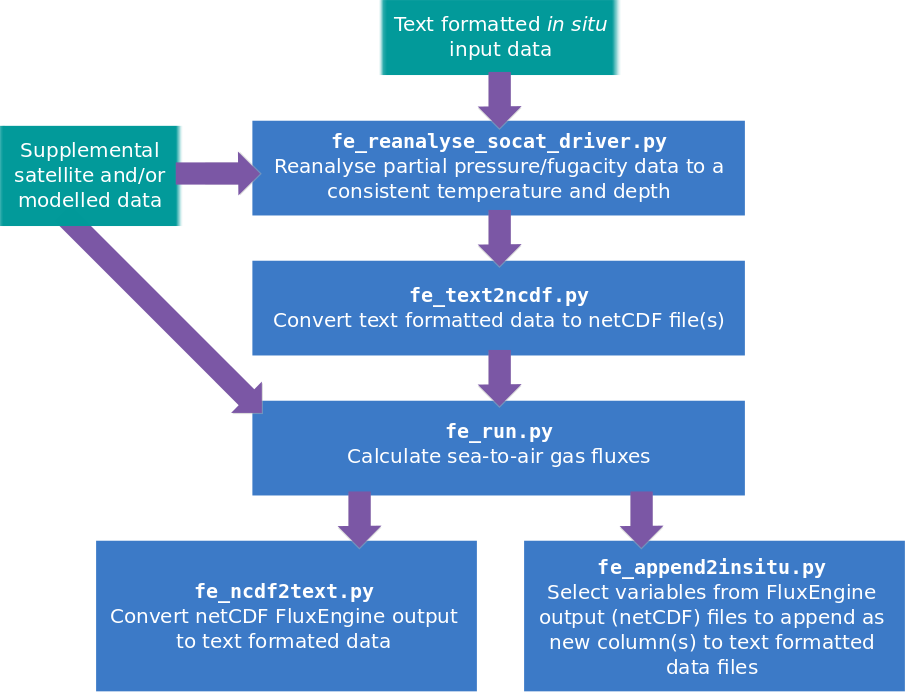

<b>Step 1)</b> In situ fugacity of CO<sub>2</sub> (fCO<sub>2</sub>) measurements are often made from differing depths and can make use of different instrument setups, particularly if you are using data accumulated from many different sources. FluxEngine provides a tool which enables fCO<sub>2</sub> measurements to be reanalysed to a consistent temperature and depth field.

<b>Step 2)</b> Next the data must be converted into the gridded netCDF file format that FluxEngine uses. The `fe_text2ncdf.py` tool can perform this conversion, and will automatically bin data into a specified grid resolution (calculating the mean and standard deviations where more than one data point falls into a single grid cell).

<b>Step 3)</b> With these netCDF files, FluxEngine can calculate the gas fluxes. This step uses the `fe_run.py` tool we have used in the previous tutorial.

<b>Step 4)</b> After running FluxEngine you will have the calculated gas fluxes in a gridded netCDF format, rather than the original text format of the in situ data. This might be fine but in many cases you will want the fluxes in the same format as the original in situ data. FluxEngine provides a tool to convert netCDF output files into text files (`fe_ncdf2text.py`) and another tool to directly append FluxEngine output variables to the original in situ data file, `fe_append2insitu.py`.

This tutorial will demonstrate each of these steps.

## These data
We will be working with data collected from the [AMT-23](http://www.amt-uk.org/Home) (Atlantic Meridional Transect) 2013 cruise. The cruise took place in October and November of 2013. The track is shown in the figure below (image taken from the [Kitidis et al's PANGAEA data repository submission](https://doi.pangaea.de/10.1594/PANGAEA.878492) for the cruise).

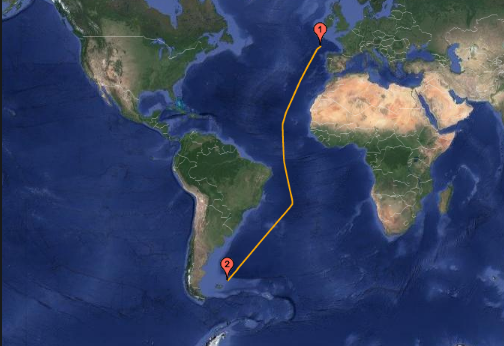

The data come with most of what we need to calculate CO<sub>2</sub> fluxes, including temperature, air pressure, salinity, atmospheric xCO<sub>2</sub> (molar fraction of CO<sub>2</sub> in dry air), and aqueous fCO<sub>2</sub>. All that is missing is wind speed. For convenience, and because we have not learnt to use the `append2insitu.py` tool yet, wind speed has been added for you by matching the closest spatial and temporal points in the [Cross-Calibrated Multi-Platform (CCMP)](http://www.remss.com/measurements/ccmp/) dataset. You could do this manually, or by writing a script to just find the grid cell in the CCMP data that is closest to each in situ measurement.

We will make a copy of the AMT-23 data (with appended wind speed columns) in our working directory. Since we are copying data aready, we will also copy some sea surface temperature (SST) data while will be used later in this tutorial. The SST data is the mean monthly sea surface temperature from the [Optiumum Interpolation Sea Surface Temperature (OISST)](https://www.ncdc.noaa.gov/oisst) for 2013. You could do this manually with your file browser, but for convenience the code to do this is provided below. As before, the data will be stored in `copied_data` directory.

In [ ]:
from fluxengine.core.fe_setup_tools import get_fluxengine_root; #Gets filepath to fluxengine root directory
from os import mkdir, path, getcwd; #cross-platform filepath manipulation and access to current working directly
import shutil;

#Copy in situ data
try:
    copyPath = path.join(getcwd(), "copied_data");
    shutil.copytree(path.join(get_fluxengine_root(), "tutorials", "02_using_insitu_data", "insitu_data"), copyPath);
    print("Kitidis et al (2017) AMT-23 data has been successfully copied to:", copyPath);
except Exception as e:
    print("There was a problem copying the AMT-23 data. The folder", copyPath, "may already exist. If so, try deleting it before rerunning this cell.");
    print(e);

#Copy Reynolds OISST data
try:
    copyPath = path.join(getcwd(), "copied_data", "oisst_monthly");
    shutil.copytree(path.join(get_fluxengine_root(), "tutorials", "02_using_insitu_data", "reynolds_avhrr_only_monthly_calculated_tmh"), copyPath);
    print("Monthly mean OISST data for 2013 has been successfully copied to:", copyPath);
except Exception as e:
    print("There was a problem copying the the OISST data. The folder", copyPath, "may already exist. If so, try deleting it before rerunning this cell.");
    print(e);

## Step 1) Reanalysis CO<sub>2</sub> data to a consistent temperature
The reanalysis tool calculates a new fCO<sub>2</sub> value by adjusting the measured fCO<sub>2</sub> to estimate the value it would be based a consistent surface temperature field. This is required for accurate calculation of the gas flux at the interface between the atmosphere and oceans (see [Woolf et al. 2016](https://doi.org/10.1002/2015JC011427) for a full explanation). It relies on paired in situ fCO<sub>2</sub> and temperature measurements and the difference in temperature between the in situ measurements and a surface (subskin) temperature field. The consistent subskin temperature field is typically derived from satellite observation, and here we use the [OISST dataset](https://www.ncdc.noaa.gov/oisst) described in [Reynolds et al., 2007](https://journals.ametsoc.org/doi/full/10.1175/2007JCLI1824.1) and [Banzon et al., 2016](https://www.earth-syst-sci-data.net/8/165/2016/essd-8-165-2016.html). A full description of the methodology used by the tool can be found in [Goddjin-Murphey et al](https://doi.org/10.5194/os-11-519-2015). The tool can be run as a standalone command line tool or by importing it as a Python module and calling it as a function in a custom script. As before, we will use the the command line tool method. First, lets run the build-in help function to query the tool and see what options it provides.

In [ ]:
!fe_reanalyse_fco2_driver.py -h

Notice that this follows the same syntax that we used when running FluxEngine using the command line tool in the previous tutorial: the `!` just tells the Jupyter notebook that we are running a the command via the command line (you do not need to include this if you are running the analysis directly using command prompt or terminal. The `fe_reanalyse_fco2_driver.py` is the name of the tool, and then we supply a list of options (in this case a single option, `-h`, asking for the help information). This `-h` option ('h' standing for 'help') can be used with any of the FluxEngine command line tools to view a built-in description of the tool and its options.

Looking through the help message shows a lot of options, many of which are only occasionally used. Other options are always required, such as `input_dir` and `-input_files`, which define the path to the input data. `-output_dir` defines the directory that our reanalysed files will be saved to. `-sst_dir` and `-sst_tail` define the path to a sea surface temperature dataset to be used as the consistent temperature field. 

The tool is designed to be easily used with data that follow the format and column names of the SOCAT dataset, but our in situ data file is not formatted exactly like this. We will therefore also use the `-notsocatformat` option and specify the names of each of the required columns for time and date, longitude and latitude, salinity, in situ SST, air pressure and fCO<sub>2</sub>. The resulting command is long, but it is not complicated - most of the options are just specifying column names from our in situ data file. If there are options that you are not sure of, look them up using the `-h` option we ran above. You can also refer to the [Goddijn-Murphy paper](https://doi.org/10.5194/os-11-519-2015) for help understanding the calculation and why each of the input fields are needed. Try running it now:

In [ ]:
!fe_reanalyse_fco2_driver.py -input_dir "copied_data" -input_files "kitidis_consistent.tsv" -output_dir "output/reanalysed/kitidis/" -usereynolds -sst_dir "copied_data/oisst_monthly" -sst_tail "01_OCF-SST-GLO-1M-100-REYNOLDS_TMH.nc" -startyr 2013 -endyr 2013 -regions "kitidis" -asciioutput -notsocatformat -year_col "year" -month_col "month" -day_col "day" -hour_col "hour" -minute_col "minute" -second_col "second" -longitude_col "lon" -latitude_col "lat" -salinity_col "salinity" -salinity_sub_col "salinity_cl" -SST_C_col "temperature" -Tequ_col "temperature_eq" -air_pressure_col "air_pressure" -air_pressure_sub_col "air_pressure_cl" -air_pressure_equ_col "air_pressure_equ" -fCO2_col "fCO2water" -expocode_col 0

You will probably see some warnings like this: `FutureWarning: read_table is depreciated use read_csv instead`. This occurs because the reanalysis tool was written using an older version of a library called `pandas`. It does not effect the output.

For convenience, we will perform one more step and merge the reanalysed fCO<sub>2</sub> and SST climatology data into a single file. This is entirely optional but makes our work easier because we only need to perform the next steps on one file. The following Python script uses the `pandas` library to take the reanalysed data from October and November (this covers the entire period of the cruise) and joins them into one dataset, then adds the reanalysed data for temperature, partial pressure and fugacity as new columns in the original in situ data file. This combined file is then saved as a separate file called `kitidis_reanalysed.tsv` which we will continue to work with for the rest of the tutorial.

Do not worry if you don ot understand the specifics of the Python code below. You could equally well do this step by hand using Excel, or by using another programming language like R or Matlab.

In [ ]:
import pandas as pd #allows using data frames
import numpy as np #matrix manipulation

#read the original in situ data and the reanalysed data.
#Note that the in situ data only covers October and November.
insituDf = pd.read_table(path.join("copied_data", "kitidis_consistent.tsv"), sep="\t")
reanOct = pd.read_table("output/reanalysed/kitidis/output/reanalysed_data/10/kitidis_from_2013_to_2013_10_custom_insitu.txt", sep=",")
reanNov = pd.read_table("output/reanalysed/kitidis/output/reanalysed_data/11/kitidis_from_2013_to_2013_11_custom_insitu.txt", sep=",")

#Create and populate columns with each of the variables we want from the reanalysed data
#The first part of each column uses data from October and the second part uses data from November
#to create a continuous time series which is consistent with the in situ file.
SST_C = np.empty(len(insituDf)); #in situ SST
SST_C[0:len(reanOct)] = reanOct["SST_C"]
SST_C[len(reanOct):] = reanNov["SST_C"]

Tcl_C = np.empty(len(insituDf)); #consistent SST field data
Tcl_C[0:len(reanOct)] = reanOct["Tcl_C"]
Tcl_C[len(reanOct):] = reanNov["Tcl_C"]

fCO2_SST = np.empty(len(insituDf)); #in situ fCO2
fCO2_SST[0:len(reanOct)] = reanOct["fCO2_SST"]
fCO2_SST[len(reanOct):] = reanNov["fCO2_SST"]

fCO2_Tym = np.empty(len(insituDf)); #reanalysied fCO2
fCO2_Tym[0:len(reanOct)] = reanOct["fCO2_Tym"]
fCO2_Tym[len(reanOct):] = reanNov["fCO2_Tym"]

pCO2_SST = np.empty(len(insituDf)); #in situ pCO2
pCO2_SST[0:len(reanOct)] = reanOct["pCO2_SST"]
pCO2_SST[len(reanOct):] = reanNov["pCO2_SST"]

pCO2_Tym = np.empty(len(insituDf)); #reanalysed fCO2
pCO2_Tym[0:len(reanOct)] = reanOct["pCO2_Tym"]
pCO2_Tym[len(reanOct):] = reanNov["pCO2_Tym"]

#Add the reanalysed columns to the in situ data.
insituDf["SST_C"] = SST_C
insituDf["Tcl_C"] = Tcl_C
insituDf["fCO2_SST"] = fCO2_SST
insituDf["fCO2_Tym"] = fCO2_Tym
insituDf["pCO2_SST"] = pCO2_SST
insituDf["pCO2_Tym"] = pCO2_Tym

#Write merged dataframe to file
f = open("output/reanalysed/kitidis/kitidis_reanalysed.tsv", mode='w')
insituDf.to_csv(f, header=True, index=False, sep="\t", float_format='%.3f')
f.close();
print("Reanalysed data successfully merged.")

## Step 2) Converting to netCDF format
FluxEngine requires input data in gridded netCDF format which means we need to convert the text formatted data into netCDF file(s). As before, FluxEngine provides two ways to do this; the `fe_text2ncdf.py` tool can be imported as a Python module or run as a standalone command line tool.

We will continue using the command line method. If you recall, the tool requires paths to the files that will be converted to netCDF (for us, this is just the single file we created in step 1), a start and stop date/time, and a list of columns to convert into netCDF variables and output file path (specified using the `--cols` option). The tool works by matching in situ measurements to a temporal and spatial grid, then calculating the mean value of all the measurements that are in a particular grid. To do this, we must specify the names (or indices) of the date/time, longitude and latitude columns so the tool can match in situ measurements to grid cells. In our in situ data file, the date column is the 7th column along (indexing starts from 0) and our latitude and longitude data are stored in columns named 'lat' and 'lon'. We therefore use `--dateIndex 7 --latProd "lat" --lonProd "lon"` in our command line option. Finally the spatial and temporal resolution can be specified. For our purposes we will analyse the whole cruise together as a single time point, so we set the temporal resolution to 60 days (enough to span the period of the cruise) using `--temporalResolution "60 00:00"`. The default spatial resolution of 1x1 degree will be more than adequate, so we do not need to specify this.

For more information on these settings you can view the help information by running the `text2ncdf.py` with the `-h` option. Run the command below.

In [ ]:
!fe_text2ncdf.py "output/reanalysed/kitidis/kitidis_reanalysed.tsv" --startTime "2013-10-01 00:00:00" --endTime "2013-11-15 00:00:00" --ncOutPath "output/reanalysed/kitidis/kitidis_reanalysed.nc" --temporalResolution "60 00:00" --cols 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 --dateIndex 7 --latProd "lat" --lonProd "lon"

If all goes well you will see a message saying "Finished converting text file to netCDF3". You might see a message telling you there were 6 missing values. This is not anything to worry about, and just refers to cases where there are missing values (e.g. NaNs / not-a-numbers) in input data.

Open the netCDF file we have just created in Panoply to view its contents. You can find it in `output/reanalysed/kitidis/kitidis_reanalysed.nc`. You will see that there are count, mean and standard deviation variables for each of the columns we converted. The count data stores the number of data points which were used to calculate the mean and standard deviation for each grid cell. Double click a few of the variables to plot them and check that they look sensible.

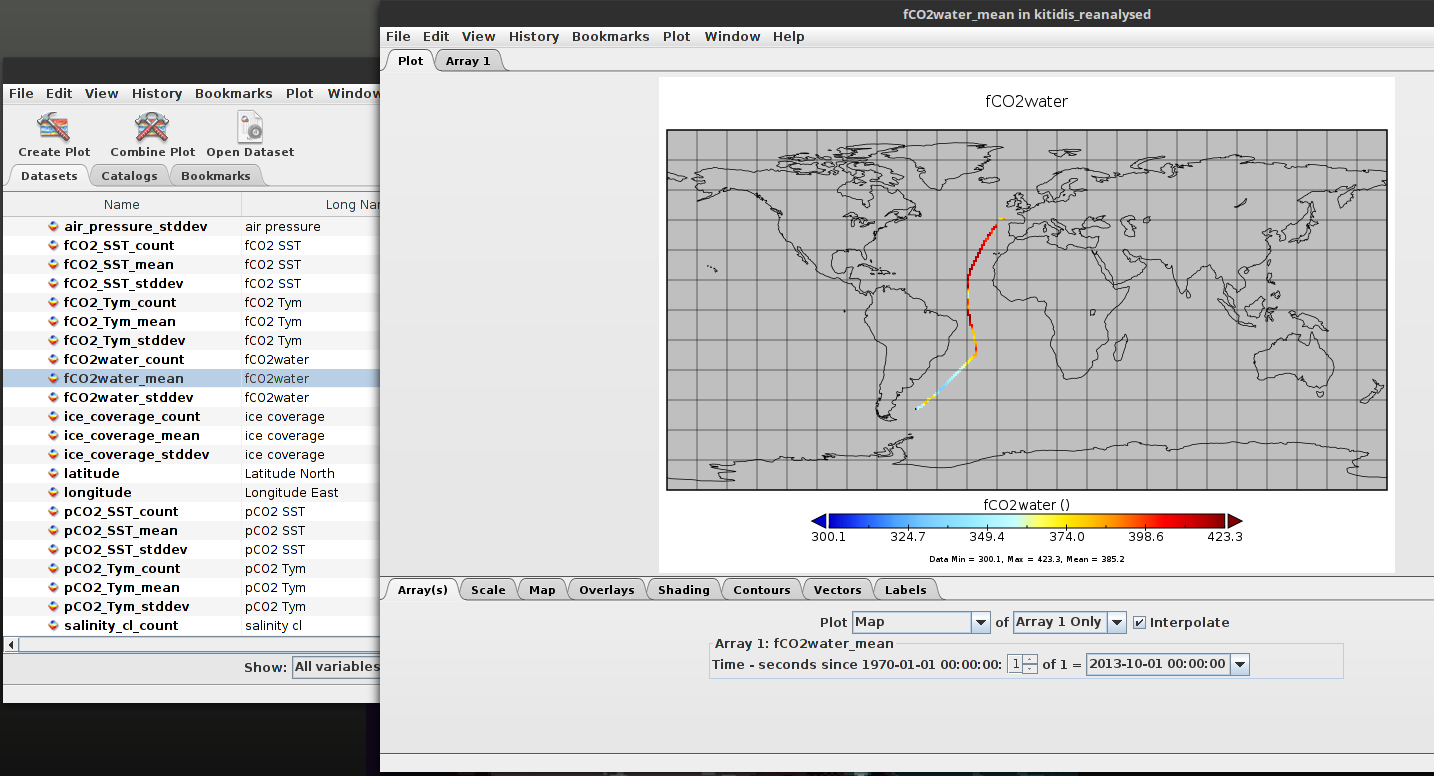


## Step 3) Running FluxEngine
Now that we have the reanalysed data in netCDF format, we can use FluxEngine to calculate the air-sea CO<sub>2</sub> fluxes! We need to create a configuration file to tell FluxEngine to use our new netCDF file as input. For convenience this has been created for you. First, copy the configuration file to our working directory:

In [ ]:
from fluxengine.core.fe_setup_tools import get_fluxengine_root;
from os import path, getcwd;
import shutil;
try:
    copyPath = path.join(os.getcwd(), "kitidis_cruise_W14_reanalysed.conf");
    shutil.copy(path.join(get_fluxengine_root(), "tutorials", "02_using_insitu_data", "kitidis_cruise_W14_reanalysed.conf"), copyPath);
    print("Configuration file successfully copied to:", copyPath);
except Exception as e:
    print("There was a problem copying the configuration file:");
    print(e);

You will see that there is a new file stored at in your working directory called `kitidis_cruise_W14_reanalysed.conf`. Open this with a text editor such as notepad++ to view it. The only significant difference between this configuration file and the one you created in the first tutorial is the selected input data and the temporal resolution.

<i>Input data</i> - If you scroll down to the section where input data is specified ou can see that for every input we are using the same netCDF file (the one we generated in step 2), but that we use different product names to access the different variables within the netCDF file. Notice as well that we are using the reanalysed version of the fCO<sub>2</sub> data (`fCO2_Tym_mean`) along with the sea surface temperature climatology (`Tcl_C_mean`).

<i>Temporal resolution</i> - We want FluxEngine to calculate fluxes for the whole cruise track as a single file rather than as separate monthly (or some other time step) files. To do this we use the `temporal_resolution` option, setting its value to `60 00:00` which indicates a timestep of 60 days, 0 hours and 0 minutes. This is a large enough interval of time to encompass the entire cruise, and so only a single time point will be generated.

Looking at the other settings you will see that we are using the 'rapid' flux equation ([see Woolf et al., 2016](https://doi.org/10.1002/2015JC011427) for details), and the [Wanninkhof 2014](https://aslopubs.onlinelibrary.wiley.com/doi/pdf/10.4319/lom.2014.12.351) gas transfer parameterisation and Schmidt number parameterisation.

Now we have our configuration file, we will calculate the air-sea CO<sub>2</sub> fluxes using the command line tool we used in the previous tutorial. The command is essentially the same: we have just updated the configuration file name/path and the start and end dates.

In [ ]:
!fe_run.py "kitidis_cruise_W14_reanalysed.conf" -s "2013-10-01" -e "2013-11-15" -l

If all goes well you will see a "completed successfully" message at the end. Do not worry if you see some `RuntimeWarning`s about invalid values being encountered. This is because there are a few stray NaNs (not a number) in the data. FluxEngine will just ignore these and it will not affect the calculation.

Use Panoply to open the output netCDF file located in `output/kitidis_cruise/kitidis_W14_reanalysed.nc` and check that the output looks reasonable. Use Panoply to plot the air-sea flux (OF) variable, and the gas transfer velocity variable. Take the time to explore the output and visualise any others you might be interested in.

## Step 4) Combining FluxEngine output with in situ data and visualising
So far so good; we are reanalysed the in situ fCO<sub>2</sub> data to a consistent temperature and depth, we have created a netCDF file containing our input data and used FluxEngine to calculate the gas fluxes. However, in many situtations calculating gas fluxes will be only one part of a wider analysis and it would be useful to extract variables from the FluxEngine output and put them back into our original in situ data file. We will do this now.

As before, FluxEngine provides two ways to do this: importing a module into a custom Python script or using a command line tool, and as before we will use the command line tool. The tool we will use is called `fe_append2insitu.py`, so we will run it with the `-h` help command to see how to use it.



In [ ]:
!fe_append2insitu.py -h

These help files can take some practice to understand. Where it says 'positional arguments' it lists three mandatory pieces of information that the tool needs to run: `feOutput` which specifies the path to the FluxEngine output file, `insituData` which specifies the path to the in situ data file, and `outPath` which specifies path and name of the output file that will be created. The name 'positional argument' means that these options must appear in this order, and before any other options.

Next there is a list of 'optional arguments'. These are additional pieces of information that you can specify using the single `-` or double `--` dash to indicate the option being specified. They will often have default values (stated in the description of each optional argument) and specifying a different value simply overwrites the default. We will use the `--varsToAppend` option to choose which FluxEngine output variables we would like to append to the in situ data. The tool uses the date, time and longitude and latitude fields to match up data from the in situ file and the FluxEngine output. We will therefore use the `--dateIndex` option to tell the tool which column in the in situ data contains the date information, and the `--lonCol` and `--latCol` options to specify the longitude and latitude column names.

All that is left to do is to construct our command line command and run it.

In [ ]:
!fe_append2insitu.py "output/kitidis_cruise/kitidis_W14_reanalysed.nc" "output/reanalysed/kitidis/kitidis_reanalysed.tsv" "output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv" --varsToAppend "OF" "OK3" "OSFC" "OIC1" --dateIndex 7 --lonCol "lon" --latCol "lat"

You should see a new text data file located here `output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv` that contains the original in situ data, the reanalysed fCO2 data along with the SST climatology used to calculate it, and the FluxEngine outputs for air-sea flux (`OF`), gas transfer velocity (`OK3`), aqueous concentration of CO<sub>2</sub> (`OSFC`) and interface concentration of CO<sub>2</sub> (`OIC1`).

With all this data together in one file we can easily visualise it. The Python code below will produce some time series plots, showing temperature (in situ (black) and the consistent temperature field (blue)), wind speed, molar fraction of atmospheric CO<sub>2</sub> (xCO<sub>2</sub>), sub-skin and interface concentration of CO<sub>2</sub> and the sea-to-air CO<sub>2</sub> flux. Do not worry if you do not understand the Python code below - you could visualise the data using any visualisation tools you like. The important thing is to understand the steps we have taken to get here.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

#Returns time elapsed between baselineDate and date in days (fractions of days allowed).
def calc_fraction_days(baselineDate, date):
    delta = date-baselineDate;
    fractionDays = delta.days + (delta.seconds) / (24*60*60.0);
    return fractionDays;

#Time series plots
#Make a copy of the data kitidis
data = pd.read_table("output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv", sep="\t", parse_dates=[7])

#Rename columns to remove units for matplotlib to function correctly
newColNamesMap = {colName:colName.split('[')[0].strip() for colName in data.keys()};
data = data.rename(index=str, columns=newColNamesMap);

#Calculate time in fractions of days
baselineDate = datetime(2013, 10, 9); #First day of data in the kitidis dataset
time = [calc_fraction_days(baselineDate, d) for d in data["datetime"]];
data["fraction_days"] = time;
initialDiscard = 750; #Note that there is a problem with the xCO2 data. This just ignore the first section of the data for purely cosmetic reasons.
time = np.array(time) - time[initialDiscard];
time = time[initialDiscard:];

#Plotting settings
pad = 10; #padding between y axis and labels
rot = 90; #y label rotation
labelsize = 14;
ticksize = 14;

alpha = 0.85;
diffColour = (0.4, 0.4, 0.4);

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, sharey=False, figsize=[10,13]);
plt.xlabel("time (days since 16-10-2013)", fontsize=labelsize);
plt.tick_params(labelsize=ticksize);

ax1.plot(time, data["temperature"][initialDiscard:], 'k', linewidth=2, alpha=alpha, label="in situ"); #Temp [°C]
ax1.plot(time, data["Tcl_C"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="satellite"); #Temp [°C]
ax1.set_ylabel("SST\n($^{\circ}C$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax1.tick_params(labelsize=ticksize);
ax1.grid(True);   
ax1.legend(loc=0, fontsize=ticksize);
    
ax2.plot(time, data["windspeed"][initialDiscard:], 'b', linewidth=2, alpha=alpha); #windspeed [m s-1]
ax2.set_ylabel("wind speed\n($ms^{-1}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax2.tick_params(labelsize=ticksize);
ax2.grid(True);

ax3.plot(time, data["xCO2air"][initialDiscard:], 'b', linewidth=2, alpha=alpha); #xCO2air_interp [µmol/mol]
ax3.set_ylabel("xCO$_{2}$\n($\mu mol/mol$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax3.tick_params(labelsize=ticksize);
ax3.grid(True);
    
ax4.plot(time, data["fCO2_SST"][initialDiscard:], 'k', linewidth=2, alpha=alpha, label="in situ"); #fCO2water_SST_wet [µatm]
ax4.plot(time, data["fCO2_Tym"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #fCO2water_SST_wet [µatm]
ax4.set_ylabel("$fCO_{2}$\n($\mu atm$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax4.tick_params(labelsize=ticksize);
ax4.grid(True);
ax4.legend(loc=3, fontsize=ticksize);

ax5.plot(time, data["OSFC"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax5.set_ylabel("sub-skin\nconcentration\n$CO_{2}$ ($gCm^{-3}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax5.tick_params(labelsize=ticksize);
ax5.grid(True);
    
ax6.plot(time, data["OIC1"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax6.set_ylabel("interface\nconcentration\n$CO_{2}$ ($gCm^{-3}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax6.tick_params(labelsize=ticksize);
ax6.grid(True);

ax7.plot(time, data["OF"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax7.set_ylabel("$CO_{2}$ flux\n($gCm^{-2}day^{-1}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax7.tick_params(labelsize=ticksize);
ax7.grid(True);
    
plt.tight_layout();
plt.subplots_adjust(hspace = 0.1);
plt.show()

## Next steps
These first two tutorials have covered the basics and you should be able to use the configuration files, command line tools and workflow described in them as the basis to run your own air-sea gas flux calculations. There are two more tutorials which cover different aspects. The can be worked through in any order depending on your interest.

 - [Calculating air-sea CO<sub>2</sub> fluxes from a fixed station in the Baltic Sea](../03_fixed_station_data/03_fixed_station_data.ipynb).
 - [Calculating air-sea fluxes for N<sub>2</sub>O for an AMT cruise](../04_N2O_fluxes/04_n2o_fluxes.ipynb).
